In [1]:
import gym
import tensorflow as tf
from tensorflow import keras, optimizers
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
problem = "Pendulum-v0"
env = gym.make(problem)
num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

In [3]:
print(num_states, num_actions, upper_bound, lower_bound)

3 1 2.0 -2.0


In [4]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None) :
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()
    
    def __call__(self) :
        x = (
            self.x_prev 
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        self.x_prev = x
        return x
    
    def reset(self) :
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else :
            self.x_prev = np.zeros_like(self.mean)

In [5]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64) :
        #Number of experiences to store at max 
        self.buffer_capacity = buffer_capacity
        #Number of tuples to train on
        self.batch_size = batch_size
        #Number of times record() is called
        self.buffer_counter = 0
        
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity,1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
    
    # Takes (s,a,r,s') observation tuple as input
    def record(self, obs_tuple) :
        # set index to 0 if capacity is met
        # replace old records
        index = self.buffer_counter % self.buffer_capacity
        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        self.buffer_counter += 1
    
    @tf.function
    def update(self, state_batch, action_batch, 
               reward_batch, next_state_batch):
        #training + updating actor-critic network
        with tf.GradientTape() as tape :
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions], training=True)
            critic_value = critic_model([state_batch,action_batch],training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))
        
        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(zip(critic_grad, critic_model.trainable_variables))
        
        with tf.GradientTape() as tape :
            actions = actor_model(next_state_batch, training=True)
            critic_value = critic_model([state_batch,actions],training=True)
            actor_loss = -tf.math.reduce_mean(critic_value)
        
        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(zip(actor_grad, actor_model.trainable_variables))
    
    def learn(self) :
        #get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        #get random sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)
        
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        
        self.update(state_batch, action_batch, reward_batch, next_state_batch)
        
@tf.function
def update_target(target_weights, weights, tau) :
    for (a,b) in zip(target_weights, weights) :
        a.assign(b*tau+a*(1-tau))

In [6]:
def get_actor() :
    last_init = tf.random_uniform_initializer(minval=-3e-3, maxval=3e-3)
    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation='relu')(inputs)
    out = layers.Dense(256, activation='relu')(out)
    out = layers.Dense(1, activation='tanh', kernel_initializer=last_init)(out)
    out *= upper_bound
    return tf.keras.Model(inputs, out)

def get_critic() :
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation='relu')(state_input)
    state_out = layers.Dense(32, activation='relu')(state_out)
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation='relu')(action_input)
    concat = layers.Concatenate()([state_out, action_out])
    out = layers.Dense(256, activation='relu')(concat)
    out = layers.Dense(256, activation='relu')(out)
    outputs = layers.Dense(1)(out)
    return keras.Model([state_input, action_input], outputs)

In [7]:
def policy(state, noise_object) : 
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    sampled_actions = sampled_actions.numpy() + noise
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)
    return [np.squeeze(legal_action)]

In [8]:
std_dev = 0.2
ou_noise = OUActionNoise(
    mean=np.zeros(1), 
    std_deviation=float(std_dev * np.ones(1))
)

actor_model = get_actor()
critic_model = get_critic()
target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 100
gamma = 0.99
tau = 0.005

buffer = Buffer(50000, 64)

In [9]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

Episode * 0 * Avg Reward is ==> -1449.995768629608
Episode * 1 * Avg Reward is ==> -1389.7675861513424
Episode * 2 * Avg Reward is ==> -1388.0804589714526
Episode * 3 * Avg Reward is ==> -1480.8308819802835
Episode * 4 * Avg Reward is ==> -1545.6638294631744
Episode * 5 * Avg Reward is ==> -1510.3520783908925
Episode * 6 * Avg Reward is ==> -1517.4232678020403
Episode * 7 * Avg Reward is ==> -1523.879028342743
Episode * 8 * Avg Reward is ==> -1507.559810581598
Episode * 9 * Avg Reward is ==> -1487.2994339944878
Episode * 10 * Avg Reward is ==> -1430.9480924056124
Episode * 11 * Avg Reward is ==> -1375.2727597433438
Episode * 12 * Avg Reward is ==> -1339.473898765713
Episode * 13 * Avg Reward is ==> -1302.3150820587016
Episode * 14 * Avg Reward is ==> -1275.465286829288
Episode * 15 * Avg Reward is ==> -1234.069986808111
Episode * 16 * Avg Reward is ==> -1184.905041912032
Episode * 17 * Avg Reward is ==> -1132.5318944183186
Episode * 18 * Avg Reward is ==> -1085.8989226789772
Episode * 

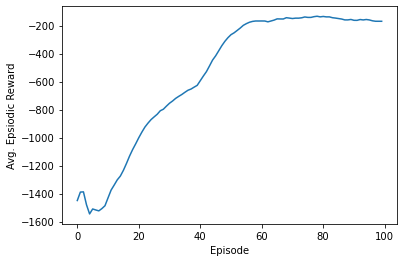

In [10]:
for ep in range(total_episodes) :
    prev_state = env.reset()
    episodic_reward = 0
    while True:
        env.render()
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state),0)
        action = policy(tf_prev_state, ou_noise)
        
        state, reward, done, _ = env.step(action)
        
        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward
        
        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)
        
        if done: 
            break
        
        prev_state = state
    ep_reward_list.append(episodic_reward)
    
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()